# Predict the state-wide true case counts

This project uses the testing rates per state (from [https://covidtracking.com/](https://covidtracking.com/)), reported case counts by state and the reported mortality rates by state to **estimate the number of unreported (untested) COVID-19 cases in each U.S. state.**

The analysis makes a few assumptions:

1. The probability that a case is reported by a state is a function of the number of tests run per person in that state.  Hence the degree of under-reported cases is a function of tests run per capita.
2. The underlying mortality rate is the same across every state.
3. Patients take time to succumb to COVID-19, so the mortality counts *today* reflect the case counts *7 days ago*.  E.g., mortality rate = (cumulative deaths today) / (cumulative cases 7 days ago).

In all, the model attempts to find the most likely relationship between state-wise test volume (per capita) and under-reporting, such that the true underlying mortality rates between the individual states are as similar as possible.  The model simultaneously finds the most likely posterior distribution of mortality rates, the most likely *true* case count per state, and the test volume vs. case underreporting relationship.

Please see the source code in [source](source).

In [1]:
# Setup and imports
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

import requests
import json
import datetime

from source import data, model

In [2]:
def get_statewise_testing_data(df_out, df_ts):
    ''' Pull all statewise data required for model fitting and
    prediction

    Returns:
    * df_out: DataFrame for model fitting where inclusion
        requires testing data from 7 days ago
    * df_pred: DataFrame for count prediction where inclusion
        only requires testing data from today
    '''
    # Get data from last week
    date_last_week = df_ts['date'].unique()[7]
    df_ts_last_week = data._get_test_counts(df_ts, df_out.index, date_last_week)
    df_out['num_tests_7_days_ago'] = \
        (df_ts_last_week['positive'] + df_ts_last_week['negative'])
    df_out['num_pos_7_days_ago'] = df_ts_last_week['positive']

    # Get data from today
    date_today = df_ts['date'].unique()[1]
    df_ts_today = data._get_test_counts(df_ts, df_out.index, date_today)
    df_out['num_tests_today'] = df_ts_today['positive'] + df_ts_today['negative']

    # State population:
    df_pop = pd.read_excel('data/us_population_by_state_2019.xlsx', skiprows=2, skipfooter=5)
    with open('data/us-state-name-abbr.json', 'r') as f:
        state_name_abbr_lookup = json.load(f)

    df_pop.index = df_pop['Geographic Area'].apply(lambda x: str(x).replace('.', '')).map(state_name_abbr_lookup)
    df_pop = df_pop.loc[df_pop.index.dropna()]

    df_out['total_population'] = df_pop['Total Resident\nPopulation']

    # Tests per million people, based on today's test coverage
    df_out['tests_per_million'] = 1e6 * (df_out['num_tests_today']) / df_out['total_population']
    df_out['tests_per_million_7_days_ago'] = 1e6 * (df_out['num_tests_7_days_ago']) / df_out['total_population']

    # People per test:
    df_out['people_per_test'] = 1e6 / df_out['tests_per_million']
    df_out['people_per_test_7_days_ago'] = 1e6 / df_out['tests_per_million_7_days_ago']

    # Drop states with messed up / missing data:
    # Drop states with missing total pop:
    to_drop_idx = df_out.index[df_out['total_population'].isnull()]
    print('Dropping %i/%i states due to lack of population data: %s' % (len(to_drop_idx), len(df_out), ', '.join(to_drop_idx)))
    df_out.drop(to_drop_idx, axis=0, inplace=True)

    df_pred = df_out.copy(deep=True)  # Prediction DataFrame

    # Criteria for model fitting:
    # Drop states with missing test count 7 days ago:
    to_drop_idx = df_out.index[df_out['num_tests_7_days_ago'].isnull()]
    print('Dropping %i/%i states due to lack of tests: %s' % (len(to_drop_idx), len(df_out), ', '.join(to_drop_idx)))
    df_out.drop(to_drop_idx, axis=0, inplace=True)
    # Drop states with no cases 7 days ago:
    to_drop_idx = df_out.index[df_out['num_pos_7_days_ago'] == 0]
    print('Dropping %i/%i states due to lack of positive tests: %s' % (len(to_drop_idx), len(df_out), ', '.join(to_drop_idx)))
    df_out.drop(to_drop_idx, axis=0, inplace=True)

    # Criteria for model prediction:
    # Drop states with missing test count today:
    to_drop_idx = df_pred.index[df_pred['num_tests_today'].isnull()]
    print('Dropping %i/%i states due to lack of tests: %s' % (len(to_drop_idx), len(df_pred), ', '.join(to_drop_idx)))
    df_pred.drop(to_drop_idx, axis=0, inplace=True)

    return df_out, df_pred

In [3]:
df_out = pd.read_parquet('states_today.parquet')
df_out.head()

,positive,positiveScore,negativeScore,negativeRegularScore,commercialScore,grade,score,negative,pending,death,total,lastUpdateEt,checkTimeEt,dateModified,dateChecked
state,,,,,,,,,,,,,,,
AK,12,1.0,1.0,1.0,1.0,A,4.0,686.0,NaN,NaN,698,3/20 16:30,3/20 16:14,1970-03-20T21:30:00Z,1970-03-20T21:14:00Z
AL,81,1.0,1.0,0.0,0.0,C,2.0,28.0,NaN,0.0,109,3/20 11:00,3/20 14:46,1970-03-20T16:00:00Z,1970-03-20T19:46:00Z
AR,96,1.0,1.0,1.0,1.0,A,4.0,351.0,203.0,NaN,650,3/20 14:19,3/20 14:48,1970-03-20T19:19:00Z,1970-03-20T19:48:00Z
AZ,65,1.0,1.0,1.0,0.0,B,3.0,211.0,101.0,0.0,377,3/20 00:00,3/20 14:52,1970-03-20T05:00:00Z,1970-03-20T19:52:00Z
CA,1063,1.0,1.0,1.0,0.0,B,3.0,10424.0,NaN,20.0,11487,3/20 14:41,3/20 14:44,1970-03-20T19:41:00Z,1970-03-20T19:44:00Z


In [4]:
df_ts = pd.read_parquet('states_daily.parquet')
df_ts.head()

,date,state,positive,negative,pending,death,total,dateChecked
0,20200320,AK,12,686.0,NaN,NaN,698,2020-03-20T20:00:00Z
1,20200320,AL,81,28.0,NaN,0.0,109,2020-03-20T20:00:00Z
2,20200320,AR,96,351.0,203.0,NaN,650,2020-03-20T20:00:00Z
3,20200320,AS,0,NaN,NaN,0.0,0,2020-03-20T20:00:00Z
4,20200320,AZ,65,211.0,101.0,0.0,377,2020-03-20T20:00:00Z


In [5]:
df, df_pred = get_statewise_testing_data(df_out=df_out, df_ts=df_ts)

Dropping 4/56 states due to lack of population data: AS, GU, MP, VI
Dropping 3/52 states due to lack of tests: GA, HI, PR
Dropping 2/49 states due to lack of positive tests: ID, WV
Dropping 0/52 states due to lack of tests: 


In [6]:
print(df.shape)
print(df_pred.shape)
print(set(df_pred.index) - set(df.index))

(47, 23)
(52, 23)
{'WV', 'ID', 'PR', 'HI', 'GA'}


In [7]:
# Initialize the model:
# import importlib
# importlib.reload(model)
mod = model.case_count_model_us_states(df)

In [8]:
# Run MCMC sampler
with mod:
    trace = pm.sample(500, tune=500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tau_logit, sigma, beta, alpha, mu_0]
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [01:35<00:00, 10.42it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


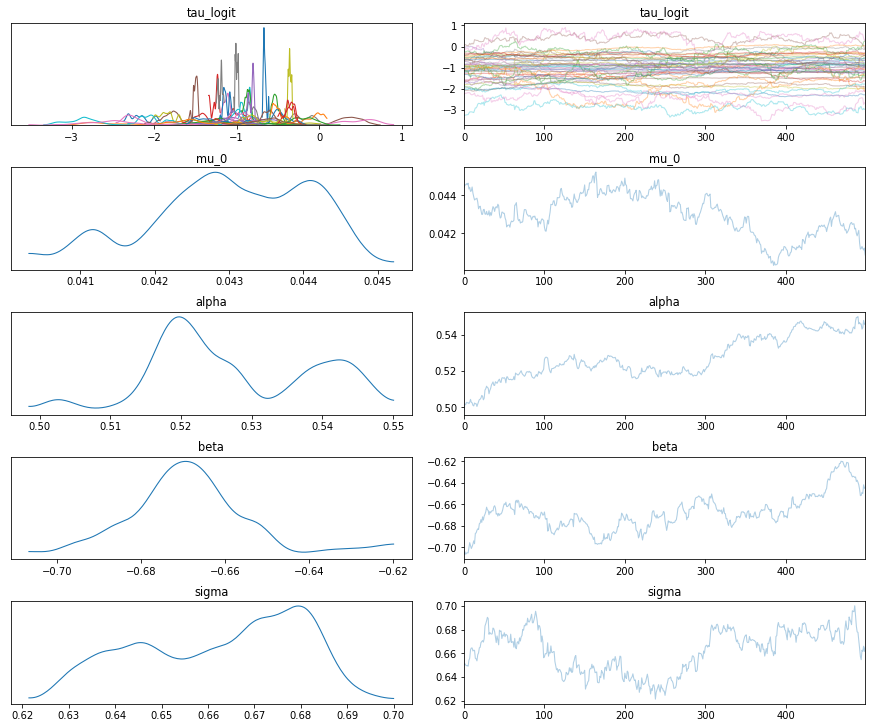

In [9]:
# Visualize the trace of the MCMC sampler to assess convergence
ax = pm.traceplot(trace)

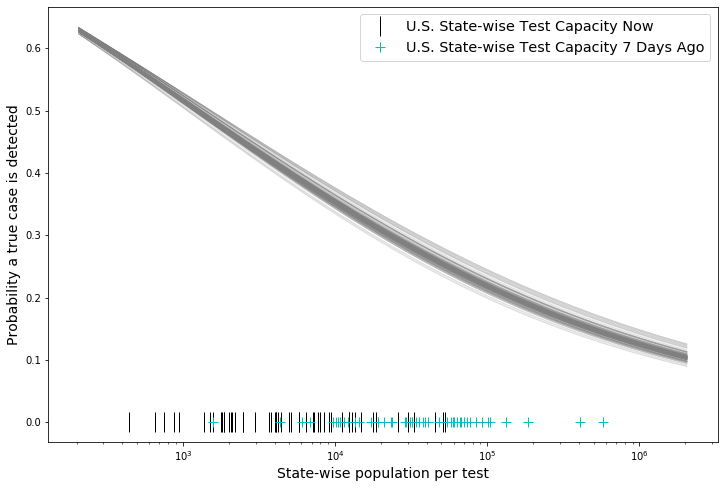

In [10]:
n = len(trace['beta'])

# South Korea:
ppt_sk = np.log10(51500000. / 250000)

# Plot pop/test vs. Prob of case detection for all posterior samples:
x = np.linspace(0.0, 4.0, 101)
logit_pcase = pd.DataFrame([
    trace['alpha'][i] + trace['beta'][i] * x
    for i in range(n)])
pcase = np.exp(logit_pcase) / (np.exp(logit_pcase) + 1)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for i in range(n):
    ax = plt.plot(10**(ppt_sk + x), pcase.iloc[i], color='grey', lw=.1, alpha=.5)
    plt.xscale('log')
    plt.xlabel('State-wise population per test', size=14)
    plt.ylabel('Probability a true case is detected', size=14)

# rug plots:
ax=plt.plot(df_pred['people_per_test'], np.zeros(len(df_pred)),
            marker='|', color='k', ls='', ms=20,
           label='U.S. State-wise Test Capacity Now')
ax=plt.plot(df['people_per_test_7_days_ago'], np.zeros(len(df)),
            marker='+', color='c', ls='', ms=10,
           label='U.S. State-wise Test Capacity 7 Days Ago')
ax = plt.legend(fontsize='x-large')

In [11]:
n = len(trace['beta'])

# South Korea:
ppt_sk = np.log10(51500000. / 250000)


# Compute predicted case counts per state right now
logit_now = pd.DataFrame([
    pd.Series(np.random.normal((trace['alpha'][i] + trace['beta'][i] * (np.log10(df_pred['people_per_test']) - ppt_sk)),
                     trace['sigma'][i]), index=df_pred.index)
    for i in range(len(trace['beta']))])
prob_missing_now = np.exp(logit_now) / (np.exp(logit_now) + 1) 

predicted_counts_now = np.round(df_pred['positive'] / prob_missing_now.mean(axis=0)).astype(int)

predicted_counts_now_lower = np.round(df_pred['positive'] / prob_missing_now.quantile(0.975, axis=0)).astype(int)
predicted_counts_now_upper = np.round(df_pred['positive'] / prob_missing_now.quantile(0.025, axis=0)).astype(int)

case_increase_percent = list(map(lambda x, y: (((x - y) / float(y))),
                                 predicted_counts_now, df_pred['positive']))

df_summary = pd.DataFrame(
    data = {
     'Cases Reported': df_pred['positive'],
     'Cases Estimated': predicted_counts_now,
     'Percent Increase': case_increase_percent,
     'Tests per Million People': df_pred['tests_per_million'].round(1),
     'Cases Estimated (range)': list(map(lambda x, y: '(%i, %i)' % (round(x), round(y)),
                                        predicted_counts_now_lower, predicted_counts_now_upper))
    },
    index=df_pred.index)
df_summary.sort_values(by='Cases Estimated', ascending=False).style.background_gradient(
    cmap='Reds').format({'Percent Increase': "{:.1%}"})

,Cases Reported,Cases Estimated,Percent Increase,Tests per Million People,Cases Estimated (range)
state,,,,,
NY,7102,13370,88.3%,1145.500000,"(8558, 30279)"
CA,1063,2503,135.5%,245.800000,"(1514, 6248)"
WA,1376,2452,78.2%,2246.300000,"(1689, 5836)"
NJ,890,2391,168.7%,107.200000,"(1330, 6284)"
IL,590,1424,141.4%,248.700000,"(807, 4242)"
FL,520,1412,171.5%,89.500000,"(785, 3794)"
MI,549,1308,138.3%,245.200000,"(743, 3477)"
LA,479,1179,146.1%,173.200000,"(665, 3475)"
GA,420,1030,145.2%,172.500000,"(589, 2758)"


In [12]:
from datetime import datetime
print("Total for the United States on %s:" % str(datetime.today())[:10])
print("Reported Case Count: %i" % df_summary['Cases Reported'].sum())
print("Predicted Case Count: %i" % df_summary['Cases Estimated'].sum())
case_increase_percent = 100. * (df_summary['Cases Estimated'].sum() - df_summary['Cases Reported'].sum()) / df_summary['Cases Estimated'].sum()
print("Percentage Underreporting in Case Count: %.1f%%" % case_increase_percent)

Total for the United States on 2020-03-20:
Reported Case Count: 17021
Predicted Case Count: 37280
Percentage Underreporting in Case Count: 54.3%


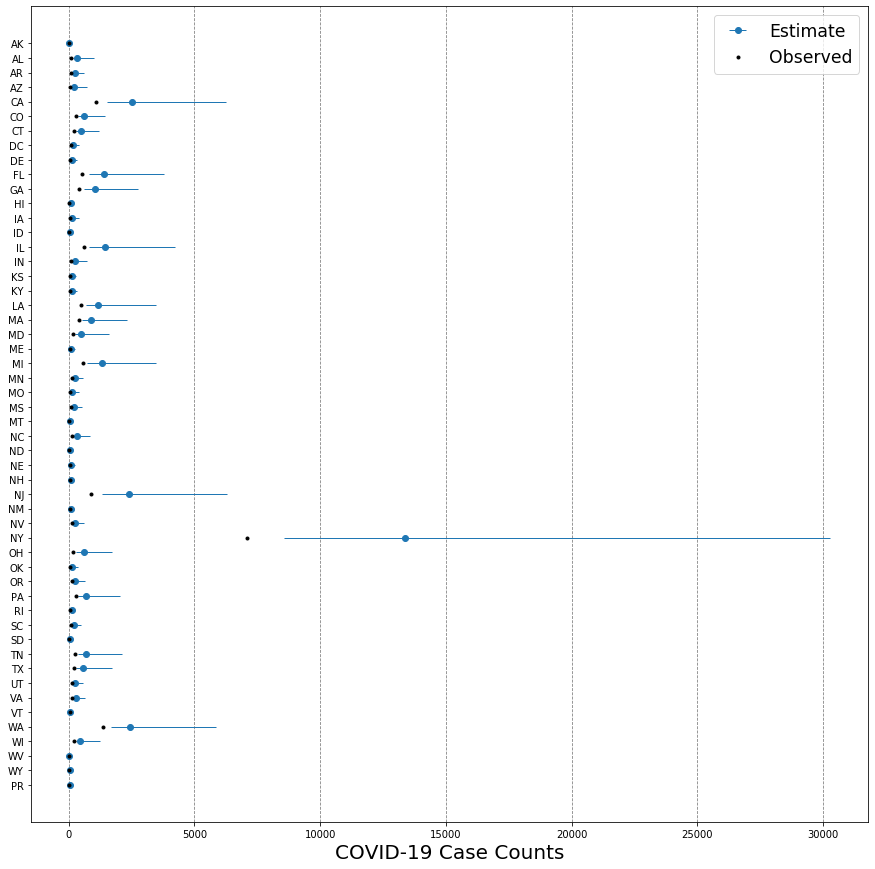

In [13]:
#collapse-hide

xerr = [df_summary['Cases Estimated'] - predicted_counts_now_lower, predicted_counts_now_upper - df_summary['Cases Estimated']]

fig, axs = plt.subplots(1, 1, figsize=(15, 15))
ax = plt.errorbar(df_summary['Cases Estimated'], range(len(df_summary)-1, -1, -1), xerr=xerr,
                  fmt='o', elinewidth=1, label='Estimate')
ax = plt.yticks(range(len(df_summary)), df_summary.index[::-1])
ax = plt.errorbar(df_summary['Cases Reported'], range(len(df_summary)-1, -1, -1), xerr=None,
                  fmt='.', color='k', label='Observed')
ax = plt.xlabel('COVID-19 Case Counts', size=20)
ax = plt.legend(fontsize='xx-large')
ax = plt.grid(linestyle='--', color='grey', axis='x')

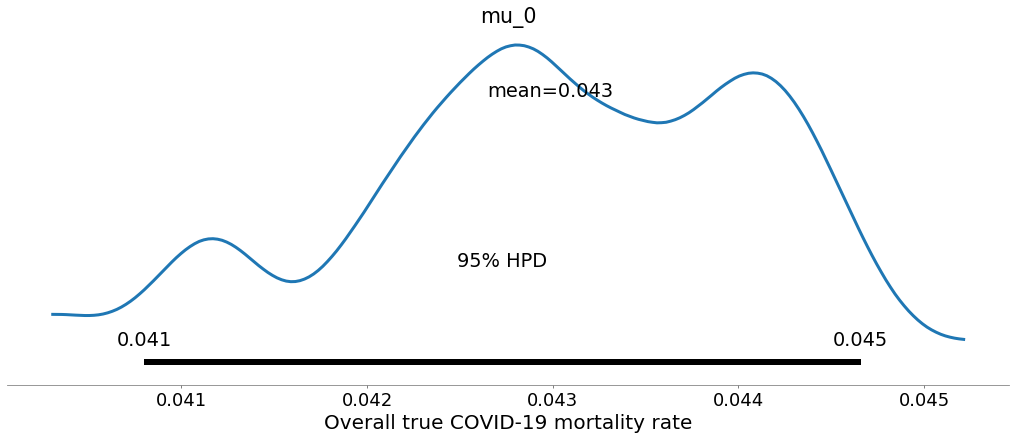

In [14]:
# Posterior plot for mu0
ax = pm.plot_posterior(trace, var_names=['mu_0'], figsize=(14, 6), textsize=18,
                       credible_interval=0.95, bw=5.0, lw=3, kind='kde')
ax = plt.xlabel('Overall true COVID-19 mortality rate', size=20)